## Proyecto Final Inteligencia Artificial - Satisfacción de los pasajeros de una Aerolinea

Desarrollado por: Juanita Marulanda Argüello y Yorman Adrian Vera Rozo

Se tiene como objetivo la predicción de qué tan satisfechos (satisfecho o no satisfecho)
se encuentran los usuarios con una aerolínea. El dataset se encuentra en
https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction.
Los datos de entrenamiento tiene una cantidad de 103904 muestras, con las siguientes características:
- "Gender"
- "Customer Type"
- "Age","Class"
- "Inflight wifi service"
- "Ease of Online booking"
- "Gate location","Food and drink"
- "Online boarding","Seat comfort"
- "Inflight entertainment"
- "On-board service","Leg room service"
- "Baggage handling","Checkin service"
- "Inflight service"
-Y como etiquetas tiene:
- "satisfaction"

Librerías utilizadas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


Limpieza y preprocesamiento de los datos

In [ ]:

data = pd.read_csv("train.csv", sep=",") # Importar los datos
test = pd.read_csv("test.csv", sep=",") # Importar los datos

print("Los datos vacios en train son: \n")
print(data.isnull().sum()) #Se mira cuales columnas les falta datos

print("Los datos vacios en test son: \n")
print(test.isnull().sum()) #Se mira cuales columnas les falta datos

# Se eliminan las columnas que no se utilizaran
data = data.drop(['id', 'Type of Travel', 'Flight Distance', 'Departure/Arrival time convenient', 'Departure Delay in Minutes','Arrival Delay in Minutes'], axis=1)
print("Las dimensiones del conjunto de datos son:",data.shape)

#Eliminar las filas con valores nulos o completarlos con la media de los existentes

data = data[data['Gender'].notna()]
data = data[data['Customer Type'].notna()]
data = data[data['Age'].notna()]
data = data[data['Class'].notna()]
data = data[data['Inflight wifi service'].notna()]
data = data[data['Ease of Online booking'].notna()]
data = data[data['Gate location'].notna()]
data = data[data['Food and drink'].notna()]
data = data[data['Online boarding'].notna()]
data = data[data['Seat comfort'].notna()]
data = data[data['Inflight entertainment'].notna()]
data = data[data['On-board service'].notna()]
data = data[data['Leg room service'].notna()]
data = data[data['Baggage handling'].notna()]
data = data[data['Checkin service'].notna()]
data = data[data['Inflight service'].notna()]
data = data[data['satisfaction'].notna()]

print("Las nuevas dimensiones del conjunto de datos son:",data.shape)

data.loc[data['Gender'] == 'Male', 'Gender'] = '1'
data.loc[data['Gender'] == 'Female', 'Gender'] = '0'

data.loc[data['Customer Type'] == 'Loyal Customer', 'Customer Type'] = '1'
data.loc[data['Customer Type'] == 'disloyal Customer', 'Customer Type'] = '0'

data.loc[data['Class'] == 'Business', 'Class'] = '2'
data.loc[data['Class'] == 'Eco Plus', 'Class'] = '1'
data.loc[data['Class'] == 'Eco', 'Class'] = '0'

data.loc[data['satisfaction'] == 'satisfied', 'satisfaction'] = '1'
data.loc[data['satisfaction'] == 'neutral or dissatisfied', 'satisfaction'] = '0'



Los datos vacios en train son: 

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes

Crear csv con datos limpios.

In [ ]:
clean_data = pd.DataFrame(data, columns = ['Gender','Customer Type','Age','Class','Inflight wifi service','Ease of Online booking','Gate location','Food and drink','Online boarding','Seat comfort','Inflight entertainment','On-board service','Leg room service','Baggage handling','Checkin service','Inflight service','satisfaction'])
#print("Datos limpios ", clean_data)

clean_data.to_csv('clean_data.csv')

Xo = pd.DataFrame(clean_data, columns = ['Gender','Customer Type','Age','Class','Inflight wifi service','Ease of Online booking','Gate location','Food and drink','Online boarding','Seat comfort','Inflight entertainment','On-board service','Leg room service','Baggage handling','Checkin service','Inflight service'])
Y  = pd.DataFrame(clean_data, columns = ['satisfaction'])



Seleccion de los datos de train y test, Normalización y PCA

In [ ]:

#--------------------Seleccionar datos train y test para el modelo (80% y 20%)-----------------------------------

X_train, X_test, Y_train, Y_test = train_test_split(Xo, Y, test_size=0.2, train_size=0.8, random_state=0)

#--------------------Funcion Nomrmalizacion(X)---------------------------------------------------

def normMinMax(Xo):
    #scaler = StandardScaler()
    #scaler.fit(Xo)
    scaler = MinMaxScaler()
    scaler.fit(Xo)
    #print(Xo)
    X = scaler.transform(Xo)
    #print(X,X.shape)
    return X


#--------------------Funcion PCA (X, Numero de componentes)-----------------------------------
def PCAfunction(X, comps):
    pca = decomposition.PCA(n_components=comps,whiten=True,svd_solver='auto')
    pca.fit(X)
    X = pca.transform(X)
    print("Pesos de PCA:",pca.explained_variance_ratio_,'\n')
    sumpca = sum(pca.explained_variance_ratio_)
    print("Se puede hacer reduccion dimensional, quedaria con ",comps,"y la suma de las componentes que quedan es:", sumpca,"\n")
    return X



Usando grid search se buscan los hiperparámetros para 3 métodos: Regresión Logística, SVM y Neuronal Networks

Pesos de PCA: [0.20956497 0.15838147 0.10814354 0.10472027 0.09434936 0.08180996
 0.05630297 0.03728755 0.03104064 0.0250475  0.02267423 0.01901948
 0.01516728 0.01473352 0.01205098] 

Se puede hacer reduccion dimensional, quedaria con  15 y la suma de las componentes que quedan es: 0.9902937492233985 

Pesos de PCA: [0.20737403 0.15547018 0.11602745 0.1066559  0.0963561  0.07646662
 0.04829494 0.03724011 0.03114435 0.02958988 0.02254236 0.01954298
 0.01772262 0.01408371 0.01203628] 

Se puede hacer reduccion dimensional, quedaria con  15 y la suma de las componentes que quedan es: 0.9905475090906904 


 matthews_corrcoef para LR:  0.5792328827392802 

Accuracy LR Test:  0.794283239497618
roc_auc LR Test:  0.7875419658423712

 Matriz de confusion para Regresion Logistica


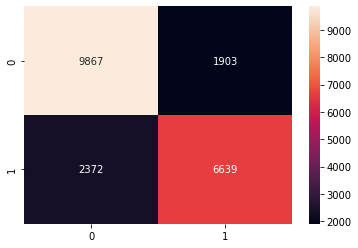


 matthews_corrcoef:  0.5792328827392802 

Accuracy:  0.794283239497618 


 matthews_corrcoef para SVM:  0.46912946879494155 

Accuracy SVM Test:  0.7354795245657091
roc_auc SVM Test:  0.736371716735903

 Matriz de confusion para Support vector Machine


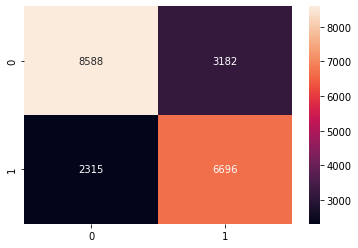


 matthews_corrcoef para ANN:  0.5656529293943204 

Accuracy ANN Test:  0.7880275251431597
roc_auc ANN Test:  0.776426503922752

 Matriz de confusion para Redes Neuronales


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:546: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_score = check_array(y_score, ensure_2d=False)


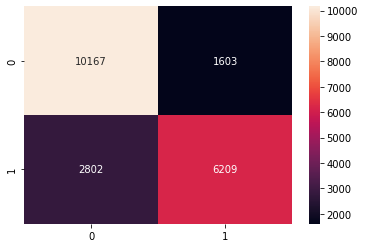

In [ ]:

Xn = normMinMax(X_train)
X_train =PCAfunction(Xn,15)


Xtn = normMinMax(X_test)
X_test =PCAfunction(Xtn,15)
'''
Se buscan los hiperparámetros por medio de GridSearch con crossvalidation.
Se entrenan los diferentes métodos con los hiperparámetros encontrados y se obtiene
accuracy y roc_auc con el conjunto de datos de test, que corresponde al 10% del dataset.

Referencia de la función GridSearch
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


'''

#-------------------- Regresión Logística---------------------------------

#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic#

LR = LogisticRegression(C=10)
LR.fit(X_train,Y_train.values.ravel())

Y_pred_LR = LR.predict(X_test)
Acc_LR = LR.score(X_test,Y_test.values.ravel())
Y_test_scores_LR = LR.decision_function(X_test)


MCC_LR = matthews_corrcoef(Y_test, Y_pred_LR)
print("\n","matthews_corrcoef para LR: ", MCC_LR,"\n")


print("Accuracy LR Test: ",Acc_LR)

Auc_LR = roc_auc_score(Y_test.values.ravel(),Y_pred_LR)
print("roc_auc LR Test: ",Auc_LR)

print("\n Matriz de confusion para Regresion Logistica")
cm_LR=confusion_matrix(Y_test.values.ravel(),Y_pred_LR)
sns.heatmap(cm_LR,annot=True,fmt='d')
plt.show()


MCC = matthews_corrcoef(Y_test, Y_pred_LR)
print("\n","matthews_corrcoef: ", MCC,"\n")
ACC = accuracy_score(Y_test, Y_pred_LR)
print("Accuracy: ", ACC,"\n")

#-------------------- Support Vector Machine -------------------------------
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

MSV = svm.SVC(kernel="sigmoid", C=10, gamma='scale')
MSV.fit(X_train,Y_train.values.ravel())

ACC = MSV.score(X_train, Y_train.values.ravel())


Y_test_predicted_SVM = (MSV.predict(X_test))
Y_test_scores = MSV.decision_function(X_test)


MCC_SVM = matthews_corrcoef(Y_test, Y_test_predicted_SVM)
print("\n","matthews_corrcoef para SVM: ", MCC_SVM,"\n")



Y_pred_SVM = MSV.predict(X_test)
Acc_SVM = MSV.score(X_test,Y_test.values.ravel())
print("Accuracy SVM Test: ",Acc_SVM)

Auc_SVM = roc_auc_score(Y_test.values.ravel(),Y_pred_SVM)
print("roc_auc SVM Test: ",Auc_SVM)

print("\n Matriz de confusion para Support vector Machine")
cm_SVM=confusion_matrix(Y_test.values.ravel(),Y_pred_SVM)
sns.heatmap(cm_SVM,annot=True,fmt='d')
plt.show()

#------------------------------Redes Neuronales--------------------------
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

ANN = MLPClassifier(hidden_layer_sizes=(100,100), activation='relu', solver='adam', alpha=10, batch_size='auto', learning_rate='adaptive', max_iter=5000)
ANN.fit(X_train,Y_train.values.ravel())


Y_test_predicted_ANN = (ANN.predict(X_test))
Y_pred_ANN = ANN.predict(X_test)

MCC_ANN = matthews_corrcoef(Y_test, Y_test_predicted_ANN)
print("\n","matthews_corrcoef para ANN: ", MCC_ANN,"\n")


Acc_ANN = accuracy_score(Y_test.values.ravel(),Y_test_predicted_ANN)
print("Accuracy ANN Test: ",Acc_ANN)

Auc_ANN = roc_auc_score(Y_test,Y_pred_ANN)
print("roc_auc ANN Test: ",Auc_ANN)


print("\n Matriz de confusion para Redes Neuronales")
cm_ANN=confusion_matrix(Y_test.values.ravel(),Y_pred_ANN)
sns.heatmap(cm_ANN,annot=True,fmt='d')
plt.show()


Usando el archivo de validación 'test.csv' se obtiene el accuracy y la roc auc para cada uno de los tres métodos implementados.

In [ ]:

#------------------Con el Conjunto de Validación TEST.csv----------------------------------------------------------


def limpiardatos(test):
    # Se eliminan las columnas que no se utilizaran
    test = test.drop(["id", "Type of Travel", "Flight Distance", "Departure/Arrival time convenient", "Departure Delay in Minutes","Arrival Delay in Minutes"], axis=1)
    print("\n Las dimensiones del conjunto de datos son:",test.shape)

    #Eliminar las filas con valores nulos o completarlos con la media de los existentes

    test = test[test["Gender"].notna()]
    test = test[test["Customer Type"].notna()]
    test = test[test["Age"].notna()]
    test = test[test["Class"].notna()]
    test = test[test["Inflight wifi service"].notna()]
    test = test[test["Ease of Online booking"].notna()]
    test = test[test["Gate location"].notna()]
    test = test[test["Food and drink"].notna()]
    test = test[test["Online boarding"].notna()]
    test = test[test["Seat comfort"].notna()]
    test = test[test["Inflight entertainment"].notna()]
    test = test[test["On-board service"].notna()]
    test = test[test["Leg room service"].notna()]
    test = test[test["Baggage handling"].notna()]
    test = test[test["Checkin service"].notna()]
    test = test[test["Inflight service"].notna()]
    test = test[test["satisfaction"].notna()]

    print("Las nuevas dimensiones del conjunto de datos son:",test.shape)

    test.loc[test["Gender"] == "Male", "Gender"] = "1"
    test.loc[test["Gender"] == "Female", "Gender"] = "0"

    test.loc[test["Customer Type"] == "Loyal Customer", "Customer Type"] = "1"
    test.loc[test["Customer Type"] == "disloyal Customer", "Customer Type"] = "0"

    test.loc[test["Class"] == "Business", "Class"] = "2"
    test.loc[test["Class"] == "Eco Plus", "Class"] = "1"
    test.loc[test["Class"] == "Eco", "Class"] = "0"

    test.loc[test["satisfaction"] == "satisfied", "satisfaction"] = "1"
    test.loc[test["satisfaction"] == "neutral or dissatisfied", "satisfaction"] = "0"


    X_val = pd.DataFrame(test, columns = ["Gender","Customer Type","Age","Class","Inflight wifi service","Ease of Online booking","Gate location","Food and drink","Online boarding","Seat comfort","Inflight entertainment","On-board service","Leg room service","Baggage handling","Checkin service","Inflight service"])
    Y_val  = pd.DataFrame(test, columns = ["satisfaction"])

    return X_val,Y_val



X_val,Y_val = limpiardatos(test)

X_val = normMinMax(X_val)
X_val =PCAfunction(X_val,15)

#Regresion Logisitica

Y_val_pred_LR = (LR.predict(X_val))
ValAcc_LR = LR.score(X_val,Y_val.values.ravel())
print("Accuracy LR Validation: ",ValAcc_LR)

ValAuc_LR = roc_auc_score(Y_val.values.ravel(),Y_val_pred_LR)
print("roc_auc LR Validation: ",ValAuc_LR)

MCC = matthews_corrcoef(Y_val, Y_val_pred_LR)
print("\n","matthews_corrcoef Regresion Logisitica: ", MCC,"\n")

#Support vector Machine

Y_val_pred_SVM = (MSV.predict(X_val))
ValAcc_SVM = MSV.score(X_val,Y_val.values.ravel())
print("Accuracy SVM Validation: ",ValAcc_SVM)

ValAuc_SVM = roc_auc_score(Y_val.values.ravel(),Y_val_pred_SVM)
print("roc_auc SVM Validation: ",ValAuc_SVM)

MCC = matthews_corrcoef(Y_val, Y_val_pred_SVM)
print("\n","matthews_corrcoef SVM: ", MCC,"\n")

#Redes Neuronales

Y_val_pred_ANN = (ANN.predict(X_val))
ValAcc_ANN = ANN.score(X_val,Y_val.values.ravel())
print("Accuracy ANN Validation: ",ValAcc_ANN)

ValAuc_ANN = roc_auc_score(Y_val.values.ravel(),Y_val_pred_ANN)
print("roc_auc ANN Validation: ",ValAuc_ANN)

MCC = matthews_corrcoef(Y_val, Y_val_pred_ANN)
print("\n","matthews_corrcoef ANN: ", MCC,"\n")




 Las dimensiones del conjunto de datos son: (25976, 19)
Las nuevas dimensiones del conjunto de datos son: (25976, 19)
Pesos de PCA: [0.20459757 0.15459192 0.10678019 0.10427878 0.1004222  0.08131066
 0.05607328 0.0460705  0.02982212 0.02482189 0.0216235  0.01843309
 0.01529223 0.01424273 0.01232763] 

Se puede hacer reduccion dimensional, quedaria con  15 y la suma de las componentes que quedan es: 0.9906882965108995 

Accuracy LR Validation:  0.8322682476131814
roc_auc LR Validation:  0.8272859829949247

 matthews_corrcoef Regresion Logisitica:  0.6583251616498929 

Accuracy SVM Validation:  0.7485756082537727
roc_auc SVM Validation:  0.7432342077193507

 matthews_corrcoef SVM:  0.4881282929482373 

Accuracy ANN Validation:  0.8338466276562981
roc_auc ANN Validation:  0.8250491456587041

 matthews_corrcoef ANN:  0.6619870657895806 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:546: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_score = check_array(y_score, ensure_2d=False)
